In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import os
import torch
import cv2
import sys
import json
from PIL import Image
from tqdm import tqdm

from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2

from dataset import *

# %matplotlib inline
%config InlineBackend.figure_format = 'retina'
print(f"Pytorch Version:[{torch.__version__}]")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"device:[{device}]")

Number of super categories: 11
Number of categories: 11
Number of annotations: 21116
Number of images: 2617
Pytorch Version:[1.7.1]
device:[cuda:0]


In [2]:
dataset_path = '/opt/ml/input/data'
train_path = dataset_path + '/train.json'
val_path = dataset_path + '/val.json'

In [151]:
def collate_fn(batch):
    return tuple(zip(*batch))

temp_transform = A.Compose([
                        # Resize(512, 512),
                        # Normalize(mean=(0.461, 0.440, 0.419), std=(0.211, 0.208, 0.216)),
#                         A.Normalize(),
                        A.Resize(256, 256),
                        ToTensorV2()
                        ])

train_transform = A.Compose([
                        # Resize(512, 512),
                        # Normalize(mean=(0.461, 0.440, 0.419), std=(0.211, 0.208, 0.216)),
                        A.Resize(256, 256),
                        A.Normalize(),
                        ToTensorV2()
                        ])

val_transform = A.Compose([
                        # Resize(512, 512),
                        # Normalize(mean=(0.461, 0.440, 0.419), std=(0.211, 0.208, 0.216)),
                        A.Resize(256, 256),                    
                        A.Normalize(), 
                        ToTensorV2()
                        ])

In [152]:
train_dataset = CustomDataLoader(data_dir=train_path, mode='train', transform=train_transform)

# validation dataset
val_dataset = CustomDataLoader(data_dir=val_path, mode='val', transform=val_transform)

temp_dataset = CustomDataLoader(data_dir=val_path, mode='val', transform=temp_transform)

loading annotations into memory...
Done (t=3.28s)
creating index...
index created!
loading annotations into memory...
Done (t=0.82s)
creating index...
index created!
loading annotations into memory...
Done (t=1.93s)
creating index...
index created!


### Inverse Normalize 동작 확인

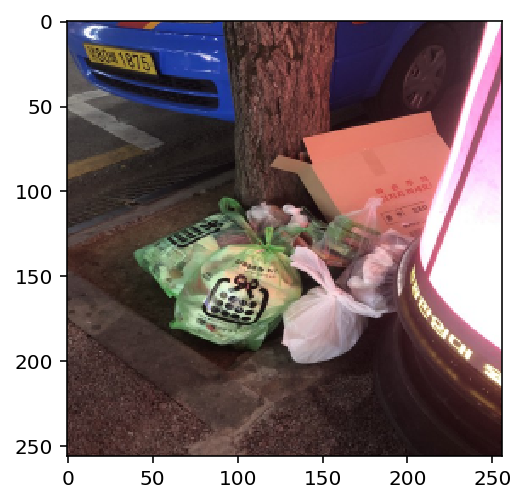

In [97]:
image, label, info = temp_dataset[3]
plt.imshow(image.permute([1, 2, 0]))

In [98]:
image.permute([1, 2, 0])[:2]

tensor([[[0.3039, 0.3206, 0.5137],
         [0.2794, 0.3029, 0.5010],
         [0.2431, 0.2676, 0.4735],
         ...,
         [0.9735, 0.9990, 0.9873],
         [0.9990, 0.9922, 0.9882],
         [0.9853, 0.9980, 0.9912]],

        [[0.2608, 0.2873, 0.4951],
         [0.2569, 0.2863, 0.4971],
         [0.2431, 0.2784, 0.4941],
         ...,
         [0.9882, 1.0000, 0.9931],
         [0.9784, 0.9912, 0.9902],
         [0.9765, 0.9304, 0.9598]]])

In [99]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

temp_norm = transforms.Normalize(mean, std)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


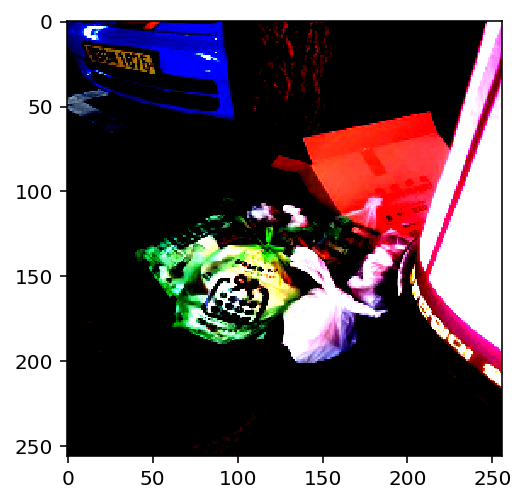

In [100]:
image = temp_norm(image)
plt.imshow(image.permute([1, 2, 0]))

In [101]:
image.permute([1, 2, 0])[:2]

tensor([[[-0.7907, -0.6045,  0.4788],
         [-0.8978, -0.6833,  0.4221],
         [-1.0562, -0.8409,  0.3001],
         ...,
         [ 2.1333,  2.4242,  2.5834],
         [ 2.2446,  2.3936,  2.5877],
         [ 2.1847,  2.4198,  2.6008]],

        [[-0.9791, -0.7533,  0.3960],
         [-0.9962, -0.7577,  0.4047],
         [-1.0562, -0.7927,  0.3916],
         ...,
         [ 2.1975,  2.4286,  2.6095],
         [ 2.1547,  2.3892,  2.5964],
         [ 2.1462,  2.1178,  2.4614]]])

In [102]:
inv_norm = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])

inv_norm(image).permute([1, 2, 0])[:2]

tensor([[[0.3039, 0.3206, 0.5137],
         [0.2794, 0.3029, 0.5010],
         [0.2431, 0.2676, 0.4735],
         ...,
         [0.9735, 0.9990, 0.9873],
         [0.9990, 0.9922, 0.9882],
         [0.9853, 0.9980, 0.9912]],

        [[0.2608, 0.2873, 0.4951],
         [0.2569, 0.2863, 0.4971],
         [0.2431, 0.2784, 0.4941],
         ...,
         [0.9882, 1.0000, 0.9931],
         [0.9784, 0.9912, 0.9902],
         [0.9765, 0.9304, 0.9598]]])

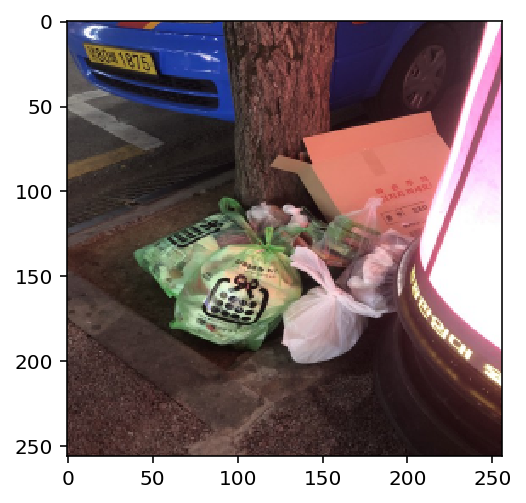

In [103]:
plt.imshow(inv_norm(image).permute([1, 2, 0]))

### 실제 Data Loader에 적용

In [153]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                        batch_size=4,
                                        shuffle=True,
                                        num_workers=4,
                                        collate_fn=collate_fn,
                                        drop_last=True)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                        batch_size=4,
                                        shuffle=False,
                                        num_workers=4,
                                        collate_fn=collate_fn,
                                        drop_last=True)

In [154]:
from torchvision import transforms


# mean = [0.461, 0.440, 0.419]
# std= [0.211, 0.208, 0.216]

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

inv_norm = transforms.Normalize(
    mean = [-m / s for m, s in zip(mean, std)],
    std = [1 / s for s in std]
)

# inv_norm = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
#                                                      std = [ 1/0.229, 1/0.224, 1/0.225 ]),
#                                 transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
#                                                      std = [ 1., 1., 1. ]),
#                                ])

# inv_norm = A.Compose([
#                 A.Normalize(
#                     mean = [-m / s for m, s in zip(mean, std)],
#                     std = [1 / s for s in std])
#                 ])

In [159]:
temp_images = next(iter(val_loader))[0]
len(temp_images)

4

In [160]:
temp_images[1][:2]

tensor([[[-2.1088, -2.1090, -2.1077,  ..., -2.1094, -2.1089, -2.1100],
         [-2.1078, -2.1081, -2.1082,  ..., -2.1087, -2.1085, -2.1078],
         [-2.1081, -2.1096, -2.1083,  ..., -2.1083, -2.1081, -2.1092],
         ...,
         [-2.1095, -2.1091, -2.1098,  ..., -2.1090, -2.1090, -2.1091],
         [-2.1097, -2.1091, -2.1085,  ..., -2.1104, -2.1090, -2.1083],
         [-2.1080, -2.1108, -2.1083,  ..., -2.1088, -2.1084, -2.1090]],

        [[-2.0264, -2.0266, -2.0253,  ..., -2.0273, -2.0268, -2.0279],
         [-2.0254, -2.0257, -2.0258,  ..., -2.0266, -2.0263, -2.0257],
         [-2.0257, -2.0272, -2.0259,  ..., -2.0262, -2.0259, -2.0270],
         ...,
         [-2.0274, -2.0269, -2.0277,  ..., -2.0267, -2.0267, -2.0268],
         [-2.0276, -2.0270, -2.0263,  ..., -2.0281, -2.0267, -2.0259],
         [-2.0260, -2.0287, -2.0262,  ..., -2.0265, -2.0261, -2.0267]]])

In [161]:
inv_norm(temp_images[1])[:2]

tensor([[[0.0021, 0.0020, 0.0023,  ..., 0.0020, 0.0021, 0.0018],
         [0.0023, 0.0023, 0.0022,  ..., 0.0021, 0.0022, 0.0023],
         [0.0022, 0.0019, 0.0022,  ..., 0.0022, 0.0023, 0.0020],
         ...,
         [0.0019, 0.0020, 0.0019,  ..., 0.0020, 0.0020, 0.0020],
         [0.0019, 0.0020, 0.0022,  ..., 0.0017, 0.0020, 0.0022],
         [0.0023, 0.0016, 0.0022,  ..., 0.0021, 0.0022, 0.0020]],

        [[0.0021, 0.0020, 0.0023,  ..., 0.0019, 0.0020, 0.0018],
         [0.0023, 0.0023, 0.0022,  ..., 0.0020, 0.0021, 0.0022],
         [0.0022, 0.0019, 0.0022,  ..., 0.0021, 0.0022, 0.0019],
         ...,
         [0.0019, 0.0020, 0.0018,  ..., 0.0020, 0.0020, 0.0020],
         [0.0018, 0.0020, 0.0021,  ..., 0.0017, 0.0020, 0.0022],
         [0.0022, 0.0016, 0.0021,  ..., 0.0021, 0.0022, 0.0020]]])

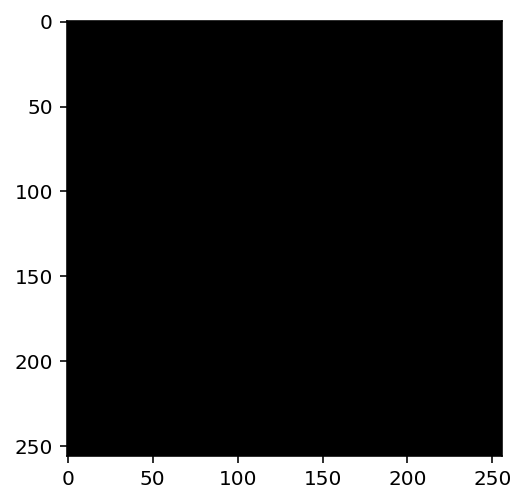

In [162]:
plt.imshow(inv_norm(temp_images[1]).permute([1, 2, 0]))

image shape: [3, 256, 256]
mask shape:  [256, 256]
Unique values, category of transformed mask : 
 [{0, 'Backgroud'}, {'General trash', 2}]
torch.Size([3, 256, 256])
torch.Size([256, 256, 3])


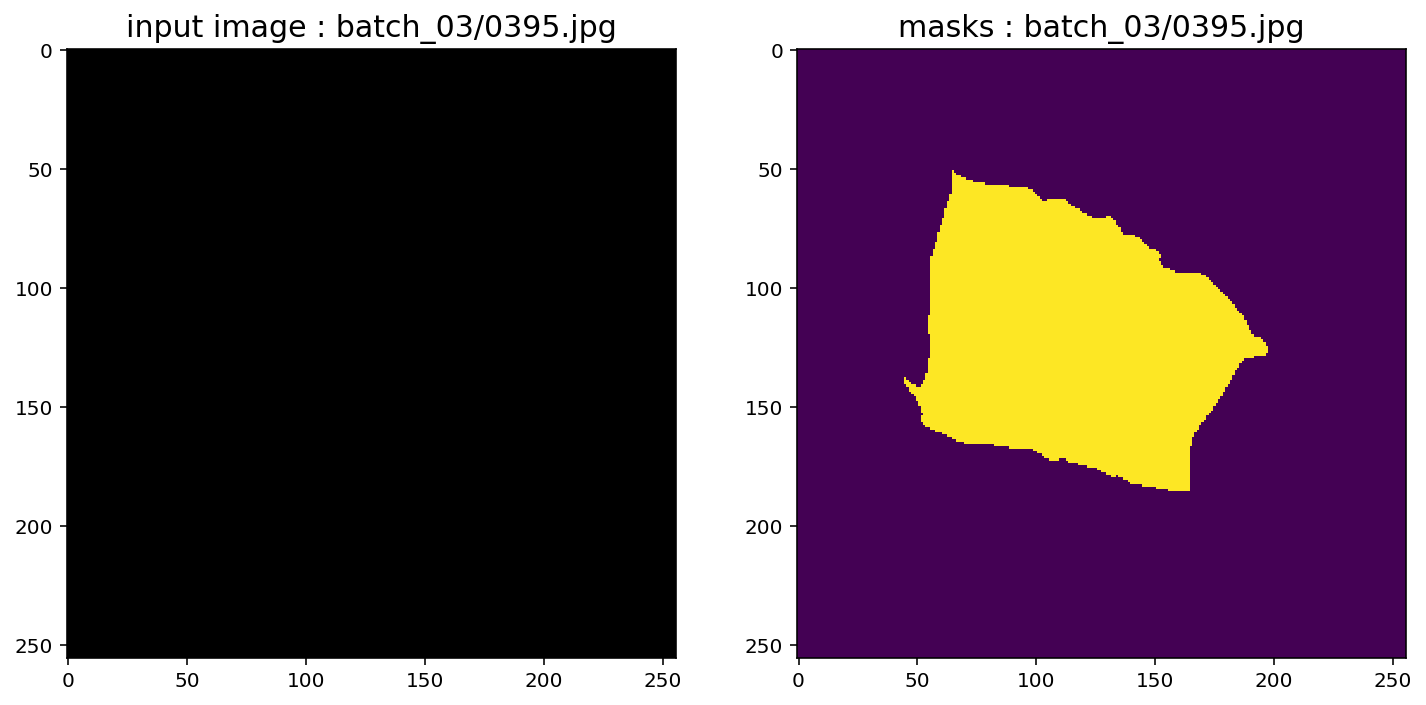

In [163]:
# train_loader의 output 결과(image 및 mask) 확인
for imgs, masks, image_infos in train_loader:
    image_infos = image_infos[0]
    temp_images = imgs
    temp_masks = masks
    
    break

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))

print('image shape:', list(temp_images[0].shape))
print('mask shape: ', list(temp_masks[0].shape))
print('Unique values, category of transformed mask : \n', [{int(i),category_names[int(i)]} for i in list(np.unique(temp_masks[0]))])

print(temp_images[0].shape)  # torch.Size([3, 256, 256])
print(temp_images[0].permute([1, 2, 0]).shape)  # torch.Size([256, 256, 3])

ax1.imshow(inv_normalize(temp_images[0]).permute([1, 2, 0]))
ax1.grid(False)
ax1.set_title("input image : {}".format(image_infos['file_name']), fontsize = 15)

ax2.imshow(temp_masks[0])
ax2.grid(False)
ax2.set_title("masks : {}".format(image_infos['file_name']), fontsize = 15)

plt.show()

image shape: [3, 256, 256]
mask shape:  [256, 256]
Unique values, category of transformed mask : 
 [{0, 'Backgroud'}, {'Glass', 6}, {'Plastic', 7}, {9, 'Plastic bag'}]


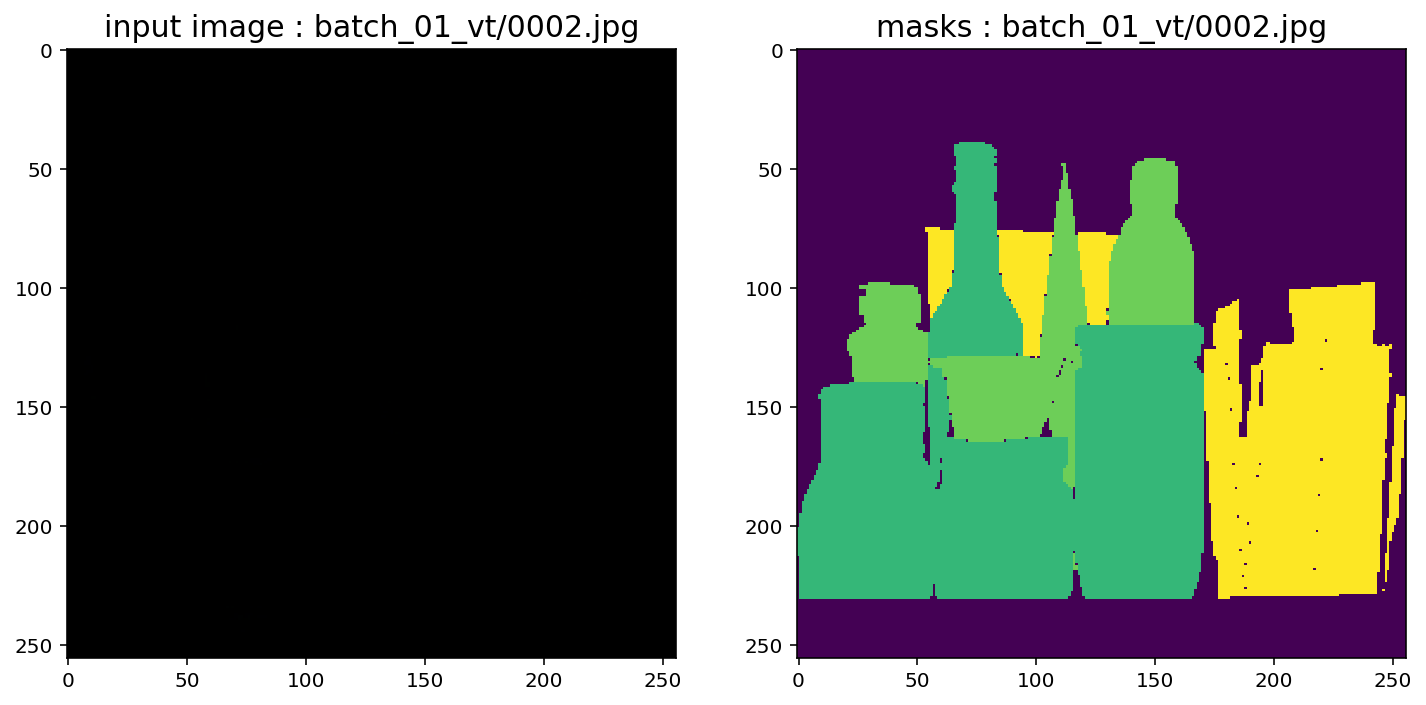

In [164]:
# val_loader의 output 결과(image 및 mask) 확인
for imgs, masks, image_infos in val_loader:
    image_infos = image_infos[0]
    temp_images = imgs
    temp_masks = masks
    
    break

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))

print('image shape:', list(temp_images[0].shape))
print('mask shape: ', list(temp_masks[0].shape))

print('Unique values, category of transformed mask : \n', [{int(i),category_names[int(i)]} for i in list(np.unique(temp_masks[0]))])

ax1.imshow(inv_normalize(temp_images[0]).permute([1,2,0]))
ax1.grid(False)
ax1.set_title("input image : {}".format(image_infos['file_name']), fontsize = 15)

ax2.imshow(temp_masks[0])
ax2.grid(False)
ax2.set_title("masks : {}".format(image_infos['file_name']), fontsize = 15)

plt.show()